# Turism in Ireland

## Data sources

https://data.cso.ie

---

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats

from skimpy import skim

from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import poisson

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

from summarytools import dfSummary

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings

# Helper Functions

In [9]:
# This function will be used inside a Data Preparatory Function to build
# a Pandas Dataframe from a Central Statistics Office Statistic Code
def cso_df(cso_stat_code):
    return pd.read_csv("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/"+ cso_stat_code +"/CSV/1.0/en")

# Note: this function could have been named cso_df_from_code
# The name has been reduced as this Jupyter is only using
# Central Statistics Office Public API to fetch the data

# Data Preparatory Functions

This section contains functions which fetch and manipulate a csv into a Pandas Dataframe. 
Using a function incapsulate all the steps required to transform the source into a table or a graph. Every function is independent from all the others.

## Overseas Trips to Ireland by Non-Residents 

## Data Preparation

In [23]:
def tma09C1_no_allcountries_simplified():
    df = cso_df("tma09")

    df = df[df["Statistic Label"]=="Overseas Trips to Ireland by Non-Residents"]

    # 2009 and 2010 there are missing values. 
    # Remove lines and restrict research to 2011-2019
    df = df[df["Year"]>=2011]

    df = df.drop(df.loc[df["Area of Residence"]=="All Countries"].index)
    
    df = df.drop(["C02173V02619", "TLIST(A1)", "STATISTIC", "Statistic Label", "UNIT"], axis=1)
    
    df = df.rename(columns={"VALUE":"TRIPS"})
    
    return df

def tma09C1_frequencies_no_allcountries():
    df = cso_df("tma09")

    df = df[df["Statistic Label"]=="Overseas Trips to Ireland by Non-Residents"]

    # 2009 and 2010 there are missing values. 
    # Remove lines and restrict research to 2011-2019
    df = df[df["Year"]>=2011]

    for year in range(2011, 2020):
        #tot = ((df.[df["Area of Residence"]=="All Countries"])[df["Year"]==year])["VALUE"].iloc[0]
        tot_year = df.loc[(df["Area of Residence"] == "All Countries") & (df["Year"]==year)]["VALUE"].iloc[0]

        df.loc[df['Year'] == year, 'VALUE'] = df[df['Year'] == year]["VALUE"]/tot_year

    df = df.drop(df.loc[df["Area of Residence"]=="All Countries"].index)
    
    df.loc[df["Area of Residence"]=="Great Britain (includes England, Scotland, Wales)", "Area of Residence"] = "Great Britain"
    df.loc[df["Area of Residence"]=="United States and Canada", "Area of Residence"] = "US and Canada"
    
    
    
    return df





In [24]:
df = tma09C1_frequencies_no_allcountries()

## Data Visualization

In [12]:
df.head()

,C02173V02619,Area of Residence,TLIST(A1),Year,STATISTIC,Statistic Label,UNIT,VALUE
39,DE,Germany,2011,2011,TMA09C1,Overseas Trips to Ireland by Non-Residents,Thousand,0.065027
42,DE,Germany,2012,2012,TMA09C1,Overseas Trips to Ireland by Non-Residents,Thousand,0.068743
45,DE,Germany,2013,2013,TMA09C1,Overseas Trips to Ireland by Non-Residents,Thousand,0.069138
48,DE,Germany,2014,2014,TMA09C1,Overseas Trips to Ireland by Non-Residents,Thousand,0.073251
51,DE,Germany,2015,2015,TMA09C1,Overseas Trips to Ireland by Non-Residents,Thousand,0.072776


## Statistics

### Overseas Trips to Ireland by Non-Residents in 2011

In [31]:
df_2011 = df.loc[df["Year"]==2011,["Area of Residence", "Year", "VALUE"]]
df_2011 = df_2011.rename(columns={"VALUE": "p(x)"})
df_2011.head(10)

,Area of Residence,Year,p(x)
39,Germany,2011,0.065027
72,France,2011,0.061645
105,Italy,2011,0.033820
138,US and Canada,2011,0.151729
171,Great Britain,2011,0.442429
204,Australia and New Zealand,2011,0.021676
237,Other Europe (14),2011,0.190469
270,Other countries (18),2011,0.033205


<Axes: xlabel='Area of Residence', ylabel='p(x)'>

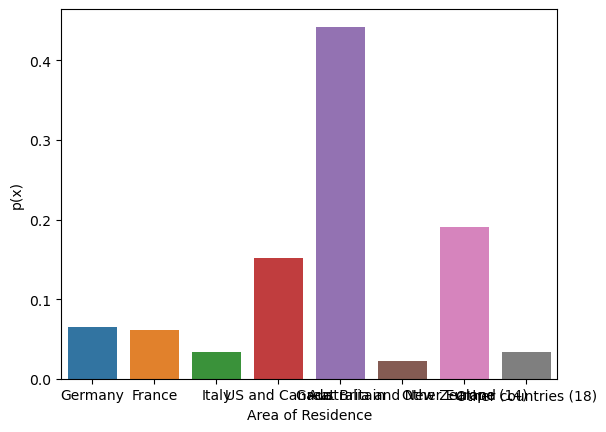

In [30]:
sns.barplot(data=df_2011, x="Area of Residence", y="p(x)")

## Dataset: Average Length of Stay by Overseas Travellers to Ireland

In [ ]:
def tma09C2_no_allcountries_simplified():
    df = cso_df("tma09")

    df = df[df["Statistic Label"]=="Average Length of Stay by Overseas Travellers to Ireland"]

    df = df.drop(df.loc[df["Area of Residence"]=="All Countries"].index)

    df = df.drop(["C02173V02619", "TLIST(A1)", "STATISTIC", "Statistic Label", "UNIT"], axis=1)

    df = df.rename(columns={"VALUE":"NIGHTS"})

    return df








# Correlation between Number of Trips and Average Number of Nights

In [ ]:
df = pd.merge(tma09C1_no_allcountries_simplified(), tma09C2_no_allcountries_simplified(), on=["Area of Residence","Year"])

sns.scatterplot(data=df, x="TRIPS", y="NIGHTS", hue="Year")


# Number of Trips by Irish Residents

## Data Preparation

In [ ]:
def htq01():
    return cso_df("htq01")

## Data Visualization

In [ ]:
htq01().head()

In [ ]:
htq01().shape

In [ ]:
htq01().info()

# Domestic Travel By Irish Residents

## Data Preparation

In [ ]:
def htq17():
    return cso_df("htq17")

## Data Visualization

In [ ]:
htq17().head()

In [ ]:
htq17().shape

In [ ]:
htq17().describe(include='all')

In [ ]:
htq17()["Reason for Journey"].value_counts()

In [ ]:
htq17()["Quarter"].value_counts()

In [ ]:
htq17()["Region Visited"].value_counts()

In [ ]:
htq17()["VALUE"].isnull().sum()

In [ ]:
htq17().hist(column='VALUE')

In [ ]:
htq17().hist(column='VALUE', bins=50)

## Dataset Statistics

In [ ]:
skim(htq17())

In [ ]:
summary = dfSummary(htq17())
summary

# Dataset: Number of Same Day Trips by Irish Residents	

## Dataset Preparation

In [ ]:
# Read csv from url
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/HTQ21/CSV/1.0/en"


In [ ]:
df = pd.read_csv(url)

## Dataset Visualization

In [ ]:
df.head()

In [ ]:
df.shape

## Dataset Statistics

In [ ]:
dfSummary(df)

# Dataset: Estimated Expenditure by Overseas Travellers to Ireland

In [ ]:
tma10_df = pd.read_csv("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/TMA10/CSV/1.0/en")

In [ ]:
tma10_df.head()

In [ ]:
tma10_df["Statistic Label"].value_counts()

In [ ]:
tma10_df.shape

## Statistics

In [ ]:
dfSummary(tma10_df)

# Overseas Trips (incl. Expenditure) to Ireland

## Data Preparation

In [ ]:
tma09_df = pd.read_csv("https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/TMA09/CSV/1.0/en")

## Data Visualization

In [ ]:
tma09_df.head(33)

In [ ]:
tma09_df.shape

In [ ]:
tma09_df.describe(include="all")

In [ ]:
dfSummary(tma09_df)

In [ ]:
tma09_df["C02173V02619"].value_counts()

In [ ]:
tma09_df_C1 = tma09_df[tma09_df["STATISTIC"]=="TMA09C1"]

In [ ]:
tma09_df_C1.head(10)

In [ ]:
# Number of Overseas Trips trend

In [ ]:
sns.barplot(x=tma09_df_C1["Year"], y=tma09_df_C1["VALUE"])

In [ ]:
# matplotlib test 


plt.style.use('_mpl-gallery')

# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]


type(y)


In [ ]:
x = tma09_df_C1["Year"].values
y = tma09_df_C1["VALUE"].values



In [ ]:
# plot
fig, ax = plt.subplots()

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

#ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

In [ ]:
#seaboarn

# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

tips.head()


In [ ]:
# PANDAS ORDER BY
tma09_df_C1.sort_values("VALUE").sort_values("Area of Residence").sort_values("Year")

In [ ]:
# PANDAS SELECT ROWS
tma09_df_C1_2019 = tma09_df_C1[tma09_df_C1["Year"]==2019]
tma09_df_C1_2019.head(100)


# PANDAS RENAME COLUMN
tma09_df_C1_2019 = tma09_df_C1_2019.rename(columns={"C02173V02619":"Country Code"})

#tma09_df_C1_2020.to_excel("tabella.xlsx")

In [ ]:
# Visualization: seaborn distplot
sns.set_theme(style="darkgrid")

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(8, 4))
 
# drawing the plot
sns.barplot(data=tma09_df_C1_2019.sort_values("VALUE")[tma09_df_C1_2019["Area of Residence"]!="All Countries"], y="Area of Residence", x="VALUE",  ax=ax)
plt.show()

#sns.lineplot(
#    tma09_df_C1_2020, x="C02173V02619", y="VALUE"
#)



In [ ]:
tma09_df_C1["Statistic Label"].unique()

In [ ]:

# Year and VALUE

sns.relplot(
    data=tma09_df_C1,
    x="Year", y="VALUE", hue="Area of Residence",
)

In [ ]:
# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

In [ ]:
tma09_df_C1.head(20)

In [ ]:
tma09_df_C1_ds = tma09_df_C1.dropna(axis=0)
tma09_df_C1_ds.head(20)

In [ ]:
tma09_df_C1_ds.isnull().values.any()

In [ ]:
tma09_df_C1_ds = tma09_df_C1_ds[tma09_df_C1_ds["Area of Residence"]!="All Countries"]

In [ ]:
# Removing columns
tma09_df_C1_ds_clean = tma09_df_C1_ds.drop(['C02173V02619', 'TLIST(A1)', 'STATISTIC', 'Statistic Label', 'UNIT'],axis=1)
# Separating dataset from labels
#tma09_df_C1_ds = tma09_df_C1.iloc[:,:7]


#tma09_df_C1_labels = tma09_df_C1_ds.iloc[:,7]
#tma09_df_C1_ds = tma09_df_C1_ds_clean
#tma09_df_C1_labels.head()


In [ ]:
tma09_df_C1_ds_clean.head()

In [ ]:
tma09_df_C1_ds_clean = tma09_df_C1_ds_clean[tma09_df_C1_ds_clean["Area of Residence"]!="All Countries"]
tma09_df_C1_ds_clean.head(100)

In [ ]:
tma09_df_C1_labels = tma09_df_C1_ds_clean.drop(["Area of Residence", "Year"], axis=1)
tma09_df_C1_labels.head()

In [ ]:
tma09_df_C1_ds_clean = tma09_df_C1_ds_clean.drop(["VALUE"], axis=1)
tma09_df_C1_ds_clean.head()

# Ordinal Encoder

In [ ]:


encoder = OrdinalEncoder()
tma09_df_C1_ds_clean["Area of Residence"] = encoder.fit_transform(tma09_df_C1_ds_clean[["Area of Residence"]])

tma09_df_C1_ds_clean.head()


In [ ]:

tma09_df_C1_train_ds,tma09_df_C1_test_ds,tma09_df_C1_train_label,tma09_df_C1_test_label = train_test_split(tma09_df_C1_ds_clean, 
                                                                tma09_df_C1_labels, test_size=0.2, random_state=42)

In [ ]:
# Linear Model


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(tma09_df_C1_train_ds, tma09_df_C1_train_label)

In [ ]:
some_data = tma09_df_C1_ds_clean.loc[:100]
some_labels = tma09_df_C1_labels.loc[:100]

In [ ]:
print(some_labels)

In [ ]:
lin_reg.predict(some_data)

In [ ]:
print(some_labels)

In [ ]:
# Measure mean_squared_error

label_predictions = lin_reg.predict(some_data)
lin_mse = mean_squared_error(some_labels, label_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
# The model is underfitting

In [ ]:
# Decision Tree Regressor -  Better than Linear Regression


tree_reg = DecisionTreeRegressor()
tree_reg.fit(tma09_df_C1_train_ds, tma09_df_C1_train_label)
label_predictions = tree_reg.predict(some_data)

tree_mse = mean_squared_error(some_labels, label_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

In [ ]:
print(some_labels)

In [ ]:
print(label_predictions)

In [ ]:
# K-fold  cross-validation for Decision Tree Regressor

scores = cross_val_score(tree_reg, tma09_df_C1_train_ds, tma09_df_C1_train_label, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [ ]:
print("Scores: ", scores)
print("Mean: ", scores.mean())
print("Std: ", scores.std())

In [ ]:
# K-fold  cross-validation for Linear Regression

scores = cross_val_score(lin_reg, tma09_df_C1_train_ds, tma09_df_C1_train_label, scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

print("Scores: ", scores)
print("Mean: ", scores.mean())
print("Std: ", scores.std())

In [ ]:
# Random Forest Regressor

forest_reg = RandomForestRegressor()
forest_reg.fit(tma09_df_C1_train_ds, tma09_df_C1_train_label)

label_predictions = lin_reg.predict(some_data)
forest_mse = mean_squared_error(some_labels, label_predictions)
forest_rmse = np.sqrt(forest_mse)
print("forest_rmse: ", forest_rmse)

scores = cross_val_score(forest_reg, tma09_df_C1_train_ds, tma09_df_C1_train_label, scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-scores)

print("Scores: ", scores)
print("Mean: ", scores.mean())
print("Std: ", scores.std())
